In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load data

In [25]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']
# load base dataframe
import pandas as pd

filepath = "/kaggle/input/input/mtg_jamendo_genre_melspecs_flattened_base_track_with_one_genre.feather"
df_base = pd.read_feather(filepath)

# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# get features
FEATURES = [c for c in df_base.columns if c.startswith('melspec_')]
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
class_weight = compute_class_weight(class_weight='balanced', 
                                    classes=np.unique(y_train), 
                                    y=y_train)
class_weight = {idx: weight for idx, weight in enumerate(class_weight)}


print(F"X_train: {X_train.shape}")
print(F"X_test:  {X_test.shape}")
print(F"class_weight:  {class_weight}")

# scale
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train, y_train)
# X_test = scaler.transform(X_test)

# # scale X_train
# X_train_mean = X_train.values.flatten().mean()
# X_train_max = X_train.values.flatten().max()
# X_train_min = X_train.values.flatten().min()
# # X_train_std = (X_train - X_train_min)/(X_train_max - X_train_min)
# X_train_std = X_train.values.flatten().std()
# X_train = (X_train - X_train_mean) / X_train_std

# # # scale X_test
# X_test_std = (X_test - X_train_min)/(X_train_max - X_train_min)
# X_test = (X_test - X_train_mean) / X_train_std

# print(F"X_train_mean: {X_train_mean}")
# print(F"X_train_max: {X_train_max}")
# print(F"X_train_min: {X_train_min}")
# print(F"X_train_std: {X_train_std}")
# print(F"X_train: {X_train.shape}")
# print(F"X_test:  {X_test.shape}")


# # min-max scale X_train
# X_train_max = X_train.values.flatten().max()
# X_train_min = X_train.values.flatten().min()
# X_train = (X_train - X_train_min) / (X_train_max - X_train_min)

# # min-max scale X_test
# X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

# print(F"X_train_max: {X_train_max}")
# print(F"X_train_min: {X_train_min}")
# print(F"X_train: {X_train.shape}")
# print(F"X_test:  {X_test.shape}")

del df_base

X_train: (4108, 65568)
X_test:  (1028, 65568)
class_weight:  {0: 4.235051546391753, 1: 0.29426934097421203, 2: 12.08235294117647, 3: 68.46666666666667, 4: 1.1474860335195531, 5: 1.4464788732394367, 6: 1.5328358208955224, 7: 0.5761570827489481, 8: 0.927313769751693, 9: 0.8070726915520628}


# Experiment 1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=50, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 2

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
layer = tf.keras.layers.Concatenate()(flattened_layers)
layer = tf.keras.layers.Dense(units=256)(layer)
layer = tf.keras.layers.Dense(units=128)(layer)
layer = tf.keras.layers.Dense(units=64)(layer)
layer = tf.keras.layers.Dense(units=32)(layer)
layer = tf.keras.layers.Dense(units=16)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=50, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 3: Groups of Conv2d layers 4->16->64

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (4,4), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (16,16), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 3
conv2d_config = {"filters": 16, "kernel_size": (64,64), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    batch_size=64,
                    epochs=50, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

2022-07-08 05:05:09.069096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 05:05:09.172639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 05:05:09.173417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 05:05:09.175013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  272         reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  4112        reshape[0][0]                    
______________________________________________________________________________________________

2022-07-08 05:05:13.223281: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.
2022-07-08 05:05:14.296618: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.
2022-07-08 05:05:15.975708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-08 05:05:18.074569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 400s 6s/step - loss: 2.5031 - accuracy: 0.1412 - val_loss: 1.9206 - val_accuracy: 0.3755
Epoch 2/50
65/65 [==============================] - 355s 5s/step - loss: 2.0765 - accuracy: 0.2453 - val_loss: 1.7189 - val_accuracy: 0.3959
Epoch 3/50
65/65 [==============================] - 354s 5s/step - loss: 1.9757 - accuracy: 0.2896 - val_loss: 1.4974 - val_accuracy: 0.4621
Epoch 4/50
65/65 [==============================] - 354s 5s/step - loss: 1.8225 - accuracy: 0.3123 - val_loss: 1.3702 - val_accuracy: 0.5029
Epoch 5/50
65/65 [==============================] - 354s 5s/step - loss: 1.7563 - accuracy: 0.3554 - val_loss: 1.3757 - val_accuracy: 0.4874
Epoch 6/50
65/65 [==============================] - 354s 5s/step - loss: 1.7208 - accuracy: 0.3635 - val_loss: 1.7325 - val_accuracy: 0.3560
Epoch 7/50
65/65 [==============================] - 354s 5s/step - loss: 1.7127 - accuracy: 0.3793 - val_loss: 1.3999 - val_accuracy: 0.4815
Epoch 8/50
65/65 [======

# Experiment 4: Conv2D 2+3

2022-07-08 18:05:44.316438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 18:05:44.414926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 18:05:44.415680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 18:05:44.417328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

2022-07-08 18:05:48.265624: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.
2022-07-08 18:05:49.350217: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.
2022-07-08 18:05:50.256969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-08 18:05:52.474503: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


129/129 [==============================] - 14s 44ms/step - loss: 2.1868 - accuracy: 0.1956 - val_loss: 1.6945 - val_accuracy: 0.3862
Epoch 2/100
129/129 [==============================] - 4s 34ms/step - loss: 1.9102 - accuracy: 0.3106 - val_loss: 1.7042 - val_accuracy: 0.3716
Epoch 3/100
129/129 [==============================] - 4s 34ms/step - loss: 1.8495 - accuracy: 0.3487 - val_loss: 1.5430 - val_accuracy: 0.4037
Epoch 4/100
129/129 [==============================] - 4s 34ms/step - loss: 1.7773 - accuracy: 0.3381 - val_loss: 1.3361 - val_accuracy: 0.5272
Epoch 5/100
129/129 [==============================] - 4s 34ms/step - loss: 1.6762 - accuracy: 0.3775 - val_loss: 1.2732 - val_accuracy: 0.5593
Epoch 6/100
129/129 [==============================] - 5s 37ms/step - loss: 1.6574 - accuracy: 0.3875 - val_loss: 1.5153 - val_accuracy: 0.4737
Epoch 7/100
129/129 [==============================] - 4s 34ms/step - loss: 1.6084 - accuracy: 0.3913 - val_loss: 1.3299 - val_accuracy: 0.5204
Epo

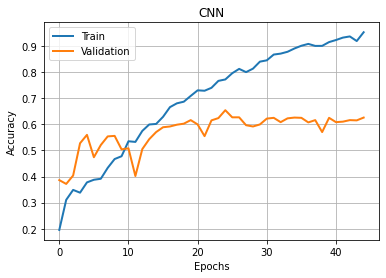

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 5: Conv2D 2+3 + Dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

2022-07-08 18:10:16.112585: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.
2022-07-08 18:10:17.266893: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.


Epoch 1/500
129/129 [==============================] - 7s 47ms/step - loss: 2.2120 - accuracy: 0.1649 - val_loss: 1.9261 - val_accuracy: 0.3862
Epoch 2/500
129/129 [==============================] - 5s 37ms/step - loss: 2.0255 - accuracy: 0.2491 - val_loss: 1.8407 - val_accuracy: 0.4183
Epoch 3/500
129/129 [==============================] - 5s 37ms/step - loss: 1.9079 - accuracy: 0.2944 - val_loss: 1.5721 - val_accuracy: 0.4767
Epoch 4/500
129/129 [==============================] - 5s 38ms/step - loss: 1.8357 - accuracy: 0.3049 - val_loss: 1.5392 - val_accuracy: 0.5097
Epoch 5/500
129/129 [==============================] - 5s 37ms/step - loss: 1.7856 - accuracy: 0.3506 - val_loss: 1.4393 - val_accuracy: 0.5311
Epoch 6/500
129/129 [==============================] - 5s 40ms/step - loss: 1.7220 - accuracy: 0.3784 - val_loss: 1.7633 - val_accuracy: 0.3580
Epoch 7/500
129/129 [==============================] - 5s 37ms/step - loss: 1.6846 - accuracy: 0.3712 - val_loss: 1.5470 - val_accuracy:

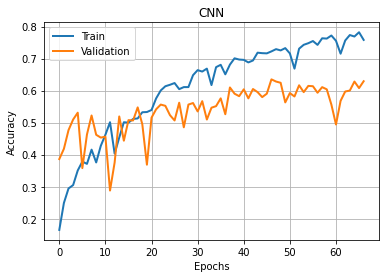

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.1)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.1)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 6: Conv2D 2+3 + Dropout = 0.2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

2022-07-08 18:16:42.898564: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1077413376 exceeds 10% of free system memory.


Epoch 1/500
129/129 [==============================] - 7s 47ms/step - loss: 2.2365 - accuracy: 0.1682 - val_loss: 2.0044 - val_accuracy: 0.3755
Epoch 2/500
129/129 [==============================] - 5s 37ms/step - loss: 2.0783 - accuracy: 0.2237 - val_loss: 1.9828 - val_accuracy: 0.3872
Epoch 3/500
129/129 [==============================] - 5s 38ms/step - loss: 2.0305 - accuracy: 0.2317 - val_loss: 1.8779 - val_accuracy: 0.3979
Epoch 4/500
129/129 [==============================] - 5s 37ms/step - loss: 2.0214 - accuracy: 0.2464 - val_loss: 1.8895 - val_accuracy: 0.4553
Epoch 5/500
129/129 [==============================] - 5s 37ms/step - loss: 1.8774 - accuracy: 0.3015 - val_loss: 1.7003 - val_accuracy: 0.5175
Epoch 6/500
129/129 [==============================] - 5s 38ms/step - loss: 1.8348 - accuracy: 0.3179 - val_loss: 1.8825 - val_accuracy: 0.2909
Epoch 7/500
129/129 [==============================] - 5s 37ms/step - loss: 1.7924 - accuracy: 0.3175 - val_loss: 1.7657 - val_accuracy:

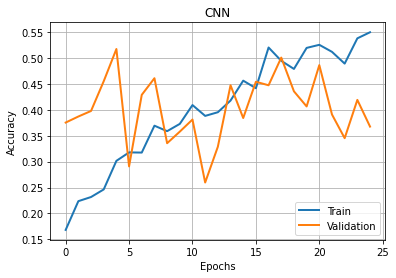

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 7: Conv2D 2+3 + Dropout = 0.3

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

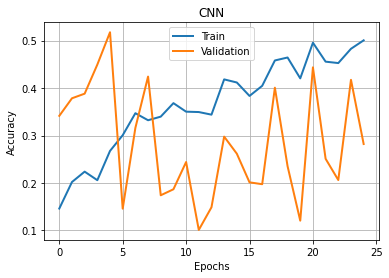

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.3)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.3)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 8: Conv2D: 2+3+5 + Dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

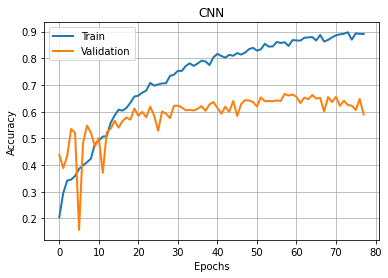

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 9: Conv2D 2+3+5+7 + Dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

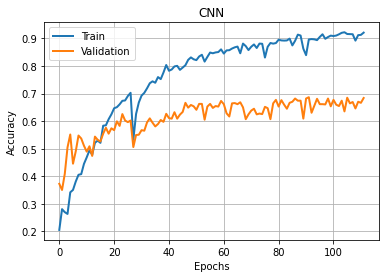

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 10: Conv2D 2+3+5+7+11 + dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

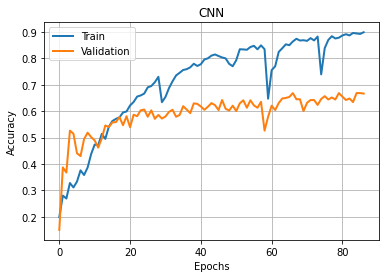

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7, 11]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 11: Conv2D 2-13 + dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

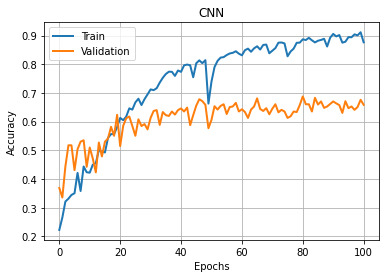

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7, 11, 13]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 12: Conv2D 2-17 + dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

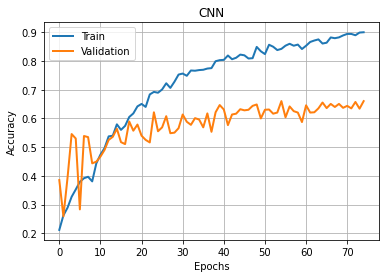

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7, 11, 13, 17]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 13: Conv2D 2+3 (double), dropout = 0.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65568)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 683, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 683, 16)  80          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 96, 683, 16)  160         reshape[0][0]                    
______________________________________________________________________________________________

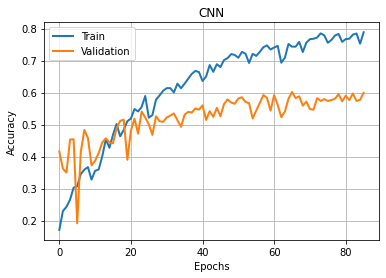

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 14: Conv2d 2, batchnorm + dropout = 0.1

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65568)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 96, 683, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 341, 16)       80        
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 341, 16)       1364      
_________________________________________________________________
dropout (Dropout)            (None, 48, 341, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 170, 16)       1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 170, 16)       680   

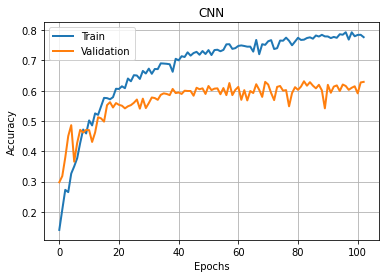

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, 
                     "kernel_size": (kernel_dim,kernel_dim), 
                     "activation": 'relu', 
                     "strides": (2,2)}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.BatchNormalization(axis=2)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()